# <center> Trabalho 04 - Introdução ao Processamento de Imagem Digital </center>

**Aluno(a):** Marianna de Pinho Severo <br>
**RA:** 264960 <br>
**Professor:** Hélio Pedrini

### Passo 1: Importar bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### Passo 2: Definir funções auxiliares

#### Passo 2.1: Funções para mostrar e salvar imagens

In [3]:
#Prints an image using matplotlib imshow method
def printImage(image):
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')

In [4]:
#Prints an image with enveloping rectangules
def printImageRectangles(labels, stats):
        # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    black_ch = np.zeros_like(label_hue)
    labeled_img = cv.merge([black_ch, black_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set backgroung label to black
    labeled_img[label_hue==0] = 0
    
    for stat in stats:
        cv.rectangle(labeled_img, (stat[0], stat[1]), (stat[0]+stat[2], stat[1]+stat[3]), (0, 255, 255), 3) 
    printImage(labeled_img)

In [5]:
#Prints the connected components with different colors
#Function based in the code from https://stackoverflow.com/questions/46441893/connected-component-labeling-in-python
def imshowComponents(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set background label to black
    labeled_img[label_hue==0] = 0
    
    printImage(labeled_img)

In [6]:
#Prints the connected components with different colors and put rectangles around them.
#Function based in the code from https://stackoverflow.com/questions/46441893/connected-component-labeling-in-python
def imshowComponentsRectagles(labels, stats):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set backgroung label to black
    labeled_img[label_hue==0] = 0
    
    for stat in stats:
        cv.rectangle(labeled_img, (stat[0], stat[1]), (stat[0]+stat[2], stat[1]+stat[3]), (255, 255, 255), 3) 
    
    printImage(labeled_img)

In [215]:
def getRectanglesImage(labels, stats):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    black_ch = np.zeros_like(label_hue)
    labeled_img = cv.merge([black_ch, black_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set backgroung label to black
    labeled_img[label_hue==0] = 0
    
    for stat in stats:
        cv.rectangle(labeled_img, (stat[0], stat[1]), (stat[0]+stat[2], stat[1]+stat[3]), (0, 255, 255), 3) 
    return labeled_img

#### Passo 2.2: Função para calcular a taxa de pixels pretos (objeto) por área, de um componente conexo

In [7]:
def getBlackPixelsRate(image,stat,color=1): #Black is considered 1 and White is considered 0
    init_x = stat[0]
    init_y = stat[1]
    dx = stat[2]
    dy = stat[3]
    
    area = (dx)*(dy)
    
    aux_image = image[init_y: init_y+dy,init_x:init_x + dx]
    aux_image = aux_image[aux_image == color]
    
    return len(aux_image)/area, len(aux_image), area

#### Passo 2.3: Função para calcular a taxa de transições de vizinhança 4 por total de pixels pretos, de um componente conexo

In [8]:
def getTransitionsRate(image, stat, total_black): #Black is 1 and White is 0
    
    if total_black == 0:
        return 0,0,0,0
    
    init_x = stat[0]
    init_y = stat[1]
    dx = stat[2]
    dy = stat[3]
    
    hor_count = 0
    ver_count = 0
    
    max_y = init_y+dy
    max_x = init_x+dx
    
    for line in range(init_y, max_y):
        for col in range(init_x, max_x):
            north = line - 1
            south = line + 1
            west = col - 1
            east = col + 1
            
            #left neighbor
            if west >= 0 and (image[line, col] == 0 and image[line,west] == 1):
                hor_count+=1
                
            # right neighbor
            if east < max_x and (image[line, col] == 0 and image[line,east] == 1):
                hor_count+=1
                
            #top neighbor
            if north >= 0 and (image[line,col] == 0 and image[north, col] == 1):
                ver_count+=1
                
            #bottom neighbor
            if south < max_y and (image[line,col] == 0 and image[south, col] == 1):
                ver_count+=1
            
    return (hor_count + ver_count)/total_black, hor_count, ver_count,total_black

### Passo 3: Ler imagem

A imagem que vamos usar neste projeto é do tipo *Portable Bitmap* (PBM). Dessa maneira, esperamos que os pixels do objeto (pixels pretos) sejam representados por valores iguais a 1 e os pixels do fundo (brancos) por valores iguais a 0.

Quando lemos essa imagem utilizando o método **imread** do *opencv*, a imagem é lida no formato monocromático, o que significa que seus valores poderão apresentar valores no intervalo de 0 a 255. Como na imagem lida só existem dois valores diferentes de pixels (0 e 255) e os valores 0 são atribuídos aos objetos, enquanto os valores 255 são atribuídos ao fundo, faremos a negação dessa imagem e dividiremos as intensidades de seus pixels por 255, de maneira a obtermos um arranjo de pixels como o esperado para uma imagem do tipo PBM. 

In [9]:
image = cv.imread('input_images/bitmap.pbm',0)
image = cv.bitwise_not(image)//255
image.shape

(1374, 2233)

### Passo 4: Definir elementos estruturantes

#### Passo 4.1: Elementos estruturantes para identificação de linhas

In [10]:
kernel1_100 = np.ones((1,100),np.uint8)
kernel1_100

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

In [11]:
kernel200_1 = np.ones((200,1), np.uint8)

In [12]:
kernel1_30 = np.ones((1,30), np.uint8)
kernel1_30

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

#### Passo 4.2: Elementos estruturantes para identificação de palavras

In [13]:
kernel6_6 = np.ones((6,6),np.uint8)
kernel6_6

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]], dtype=uint8)

In [14]:
kernel1_3 = np.ones((1,3), np.uint8)
kernel1_3

array([[1, 1, 1]], dtype=uint8)

In [15]:
kernel10_1 = np.ones((10,1), np.uint8)

In [16]:
kernel1_8 = np.ones((1,8), np.uint8)
kernel1_8

array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

Para a realização do passo 10 deste trabalho, duas abordagens serão seguidas: na primeira delas, aplicaremos os outros nove passos descritos no trabalho, o que nos permitirá identificar partes da imagem que representam texto e a contar o número de linha; a segunda abordagem também nos permitirá identificar partes da imagem que representam texto, mas também permitirá que contemos a quantidade de palavras. Suas implementação é realizada nas seções abaixo.

### Passo 5: Aplicar etapas indicadas na descrição do trabalho até a etapa 09

Todas as imagens intermediárias geradas nesta seção serão salvas no dicionário **line_processed_images**.

In [17]:
line_processed_images = {}

#### Passo 5.1: Aplicar dilatação na imagem original com elemento estruturante de 1 x 100

In [18]:
line_processed_images['dilate1_100'] = cv.dilate(np.copy(image),kernel1_100)

In [19]:
# printImage(line_processed_images['dilate1_100'])

#### Passo 5.2: Aplicar erosão, na imagem do passo anterior, com elemento estruturante de 1 x 100

In [20]:
line_processed_images['erode1_100'] = cv.erode(np.copy(line_processed_images['dilate1_100']),kernel1_100)

In [21]:
# printImage(line_processed_images['erode1_100'])

#### Passo 5.3: Aplicar dilatação na imagem original com elemento estruturante de 200 x 1

In [22]:
line_processed_images['dilate200_1'] = cv.dilate(np.copy(image),kernel200_1)

In [23]:
# printImage(line_processed_images['dilate200_1'])

#### Passo 5.4: Aplicar erosão, na imagem do passo anterior, com elemento estruturante de 200 x 1

In [24]:
line_processed_images['erode200_1'] = cv.erode(np.copy(line_processed_images['dilate200_1']),kernel200_1)

In [25]:
# printImage(line_processed_images['erode200_1'])

#### Passo 5.5: Fazer interseção das imagens produzidas nos passos 5.2 e 5.4

In [26]:
line_processed_images['inter2_4'] = cv.bitwise_and(line_processed_images['erode1_100'], line_processed_images['erode200_1'])


In [27]:
# printImage(line_processed_images['inter2_4'])

#### Passo 5.6: Aplicar fechamento, na imagem do passo anterior, com elemento estruturante de 1 x 30

In [28]:
line_processed_images['close1_30'] = cv.morphologyEx(line_processed_images['inter2_4'], cv.MORPH_CLOSE, kernel1_30)


In [29]:
# printImage(line_processed_images['close1_30'])

#### Passo 5.7: Identificação de componentes conexos na imagem do passo anterior

In [30]:
line_num_labels, line_image_labels, line_stats, line_centroids = cv.connectedComponentsWithStats(line_processed_images['close1_30'])


In [31]:
print(line_num_labels)

54


In [32]:
# imshowComponents(np.copy(line_image_labels))

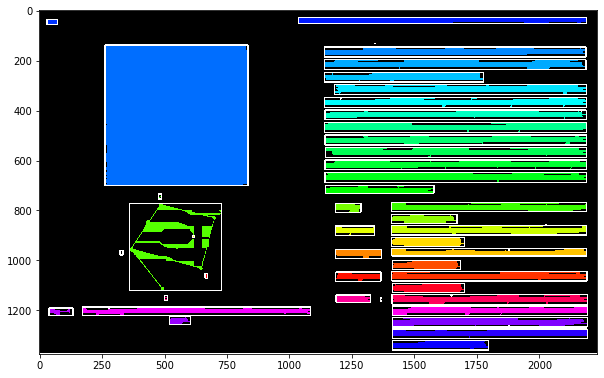

In [33]:
imshowComponentsRectagles(np.copy(line_image_labels),line_stats)

#### Passo 5.8: Calcular razões para os componentes conexos obtidos no passo anterior

##### Passo 5.8.1: Calcular razão entre o número de pixels pretos e o número total de pixels, para cada retângulo envolvendo um componente conexo

In [34]:
line_black_ratios={}
line_black_amounts = {}
line_component_areas = {}

In [35]:
for label, stat in zip(range(line_num_labels),line_stats):
    line_black_ratios[label], line_black_amounts[label], line_component_areas[label] = getBlackPixelsRate(np.copy(image),stat)

In [36]:
for label in line_black_ratios:
    print('Componente:{} | Ratio:{} | Blacks:{} | Area:{}'.format(label,line_black_ratios[label], line_black_amounts[label], line_component_areas[label]))

Componente:0 | Ratio:0.15326995947384442 | Blacks:470254 | Area:3068142
Componente:1 | Ratio:0.29763478260869564 | Blacks:8557 | Area:28750
Componente:2 | Ratio:0.36848072562358275 | Blacks:325 | Area:882
Componente:3 | Ratio:0.0 | Blacks:0 | Area:6
Componente:4 | Ratio:0.8370760255786994 | Blacks:268611 | Area:320892
Componente:5 | Ratio:0.21467495219885277 | Blacks:8982 | Area:41840
Componente:6 | Ratio:0.22251434034416825 | Blacks:9310 | Area:41840
Componente:7 | Ratio:0.2552410901467505 | Blacks:6331 | Area:24804
Componente:8 | Ratio:0.20510274234206707 | Blacks:8055 | Area:39273
Componente:9 | Ratio:0.20871537726838588 | Blacks:8741 | Area:41880
Componente:10 | Ratio:0.45 | Blacks:9 | Area:20
Componente:11 | Ratio:0.2235205237975321 | Blacks:8876 | Area:39710
Componente:12 | Ratio:0.4 | Blacks:8 | Area:20
Componente:13 | Ratio:0.2167304015296367 | Blacks:9068 | Area:41840
Componente:14 | Ratio:0.23410611854684513 | Blacks:9795 | Area:41840
Componente:15 | Ratio:0.22114463601532566

##### Passo 5.8.2: Calcular razão entre o número de transições de branco para preto e o número de pixels pretos, para cada retângulo envolvendo um componente conexo

In [37]:
line_transition_ratios={}
line_hor_tran_amount = {}
line_ver_tran_amount = {}
line_total_black_amount = {}

In [38]:
for label, stat in zip(range(line_num_labels),line_stats):
    line_transition_ratios[label], line_hor_tran_amount[label], line_ver_tran_amount[label], line_total_black_amount[label] = getTransitionsRate(np.copy(image), stat, line_black_amounts[label])

In [39]:
# for label in line_transition_ratios:
#     print('Componente:{} | Ratio:{} | Horizontal:{}, Vertical:{} | Blacks:{}'.format(label,line_transition_ratios[label], line_hor_tran_amount[label], line_ver_tran_amount[label], line_total_black_amount[label]))

#### Passo 5.9: Criar uma regra para determinar se um componente conexo é texto ou não

In [40]:
line_component_classes = {}

In [84]:
for comp_key in range(line_num_labels):
    if comp_key == 0:
        line_component_classes[comp_key] = 0
    elif line_black_ratios[comp_key] < 0.07:
        line_component_classes[comp_key] = 0
    elif line_transition_ratios[comp_key] < 0.46:
        line_component_classes[comp_key] = 0
    else:
        line_component_classes[comp_key] = 1

In [86]:
# for key in line_component_classes:
#     print("Componente:{} | Text: {}".format(key,line_component_classes[key]))

43


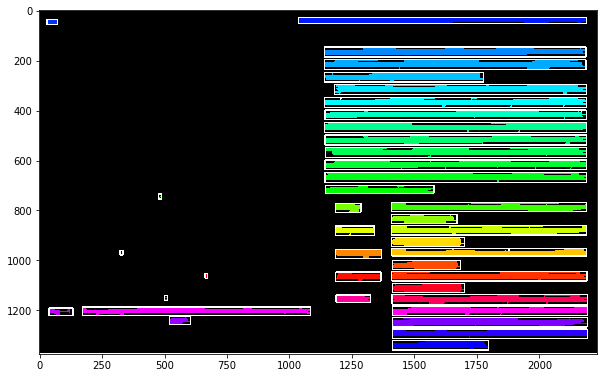

In [43]:
#To show the text selected components

text_labels = [key for key in line_component_classes if line_component_classes[key] == 1]
no_text_labels = [key for key in line_component_classes if line_component_classes[key] == 0]
text_stats = line_stats[text_labels]

text_image = np.copy(line_image_labels)
for l in no_text_labels:
    text_image[text_image == l] = 0

print(len(text_labels))
imshowComponentsRectagles(text_image, text_stats)

### Passo 06: Aplicação dos passos para identificação de texto e contagem de palavras

Todas as imagens intermediárias geradas nesta seção serão salvas no dicionário **word_processed_images**.

In [44]:
word_processed_images = {}

#### Passo 6.1: Aplicar dilatação na imagem original, com elemento estruturante 6x6

In [45]:
word_processed_images['dilate6_6'] = cv.dilate(np.copy(image), kernel6_6)

In [46]:
# printImage(word_processed_images['dilate6_6'])

#### Passo 6.2: Aplicar erosão, na imagem resultante do passo anterior, com elemento estruturante 1x3

In [47]:
word_processed_images['erode1_3'] = cv.erode(np.copy(word_processed_images['dilate6_6']), kernel1_3)


In [48]:
# printImage(word_processed_images['erode1_3'])

#### Passo 6.3: Aplicar dilatação, na imagem resultante do passo anterior, com elemento estruturante 10x1

In [49]:
word_processed_images['dilate10_1'] = cv.dilate(np.copy(word_processed_images['erode1_3']), kernel10_1)

In [50]:
# printImage(word_processed_images['dilate10_1'])

#### Passo 6.4: Aplicar erosão, na imagem resultante do passo anterior, com elemento estruturante 1x3

In [51]:
word_processed_images['erode1_3_2'] = cv.erode(np.copy(word_processed_images['dilate10_1']), kernel1_3)

In [52]:
# printImage(word_processed_images['erode1_3_2'])

#### Passo 6.5: Aplicar interseção com as imagens resultantes dos passos 6.2 e 6.4

In [53]:
word_processed_images['inter2_4_w'] = cv.bitwise_and(np.copy(word_processed_images['erode1_3']), np.copy(word_processed_images['erode1_3_2']))


In [54]:
# printImage(word_processed_images['inter2_4_w'])

#### Passo 6.6: Aplicar fechamento, na imagem do passo anterior, com elemento estruturante 1x8

In [55]:
word_processed_images['close1_8'] = cv.morphologyEx(np.copy(word_processed_images['inter2_4_w']), cv.MORPH_CLOSE, kernel1_8)


In [56]:
# printImage(word_processed_images['close1_8'])

#### Passo 6.7:  Identificação de componentes conexos na imagem do passo anterior

In [57]:
word_num_labels, word_image_labels, word_stats, word_centroids = cv.connectedComponentsWithStats(word_processed_images['close1_8'], connectivity = 8)


In [58]:
print(word_num_labels)

251


In [59]:
# imshowComponents(np.copy(word_image_labels))

In [60]:
# imshowComponentsRectagles(np.copy(word_image_labels),word_stats)

#### Passo 6.8: Calcular razões para os componentes conexos obtidos no passo anterior

##### Passo 6.8.1: Calcular razão entre o número de pixels pretos e o número total de pixels, para cada retângulo envolvendo um componente conexo

In [61]:
word_black_ratios={}
word_black_amounts = {}
word_component_areas = {}

In [62]:
for label, stat in zip(range(word_num_labels),word_stats):
    word_black_ratios[label], word_black_amounts[label], word_component_areas[label] = getBlackPixelsRate(np.copy(word_processed_images['close1_8']),stat)

In [63]:
# for label in word_black_ratios:
#     print('Componente:{} | Ratio:{} | Blacks:{} | Area:{}'.format(label,word_black_ratios[label], word_black_amounts[label], word_component_areas[label]))

##### Passo 6.8.2: Calcular razão entre o número de transições de branco para preto e o número de pixels pretos, para cada retângulo envolvendo um componente conexo

In [64]:
word_transition_ratios={}
word_hor_tran_amount = {}
word_ver_tran_amount = {}
word_total_black_amount = {}

In [65]:
for label, stat in zip(range(word_num_labels),word_stats):
    word_transition_ratios[label], word_hor_tran_amount[label], word_ver_tran_amount[label], word_total_black_amount[label] = getTransitionsRate(np.copy(word_processed_images['close1_8']), stat, word_black_amounts[label])

In [79]:
# for label in word_transition_ratios:
#     print('Componente:{} | Ratio:{} | Horizontal:{}, Vertical:{} | Blacks:{}'.format(label,word_transition_ratios[label], word_hor_tran_amount[label], word_ver_tran_amount[label], word_total_black_amount[label]))

#### Passo 6.9: Criar uma regra para determinar se um componente conexo é texto ou não

In [67]:
word_component_classes = {}

In [87]:
for comp_key in range(word_num_labels):
    if comp_key == 0:
        word_component_classes[comp_key] = 0
    elif word_black_ratios[comp_key] <= 0.27:
        word_component_classes[comp_key] = 0
    elif word_transition_ratios[comp_key] < 0.008:
        word_component_classes[comp_key] = 0
    else:
        word_component_classes[comp_key] = 1

In [81]:
# for key in word_component_classes:
#     print("Componente:{} | Text: {}".format(key,word_component_classes[key]))

242


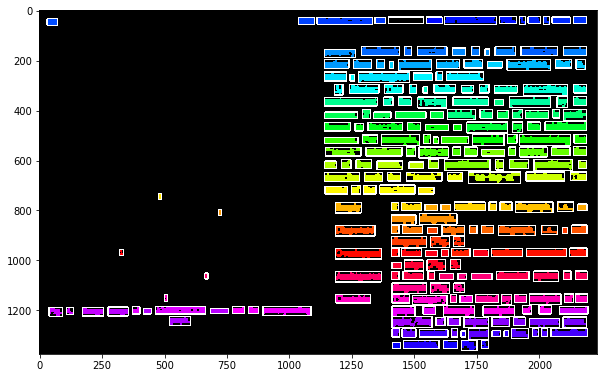

In [70]:
text_labels = [key for key in word_component_classes if word_component_classes[key] == 1]
no_text_labels = [key for key in word_component_classes if word_component_classes[key] == 0]
text_stats = word_stats[text_labels]

text_image = np.copy(word_image_labels)
for l in no_text_labels:
    text_image[text_image == l] = 0

print(len(text_stats))
imshowComponentsRectagles(text_image, text_stats)

### Passo 07: Contar o número de blocos de palavras e colocar retângulos envolventes na imagem original

#### Passo 7.1: Contar número de palavras

Como no Passo 6 identificamos os blocos de palavras existentes na imagem, para contarmos quantos deles existem, basta olharmos quantos dos itens do dicionário **word_component_classes** possuem valor igual a 1, pois foi nesse dicionário que armazenamos o resultado das regras desenvolvidas no Passo 6.9.

In [71]:
word_classes_values = np.array(list(word_component_classes.values()))
number_of_words = word_classes_values[word_classes_values == 1]
print("O número de blocos de palavras é:{}".format(len(number_of_words)))

O número de blocos de palavras é:242


#### Passo 7.2: Colocar retângulo envolvente em torno dos blocos de palavras

In [72]:
clean_word_stats = []
for key in word_component_classes:
    if word_component_classes[key]:
        clean_word_stats.append(word_stats[key])

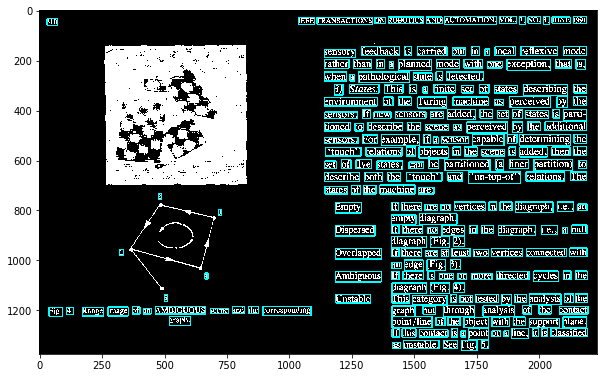

In [73]:
printImageRectangles(np.copy(image), clean_word_stats)

### Passo 08: Contar número de linhas de texto

Para contarmos o número de linhas de texto, usaremos o dicionário **line_component_classes**, cujos itens indicam quais componentes conexos são considerados textos, considerando as etapas realizadas no Passo 5. Entretanto, ao contrário do que fizemos na seção anterior, não basta contar o número de itens que possui valor igual a 1. Isso acontece porque, de acordo com as operações que foram aplicadas, podemos ter mais de um componente conexo que está na mesma linha. Assim, outros operações precisam ser realizadas contarmos apenas as linhas.

In [200]:
clean_line_stats = []
for key in line_component_classes:
    if line_component_classes[key]:
        clean_line_stats.append(line_stats[key])

In [201]:
same_line_dict = {}
for pos in range(len(clean_line_stats)-1):
    same_line_dict[pos] = []

In [202]:
for pos in range(len(clean_line_stats)):
    for pos2 in range (len(clean_line_stats)):
        if pos == pos2:
            continue
        reference = clean_line_stats[pos]
        check = clean_line_stats[pos2]
        if check[1] >= reference[1] and check[1] <= reference[1] + reference[3]:
            same_line_dict[pos].append(pos2)

In [205]:
aux_same_line_dict = same_line_dict.copy()
for key in same_line_dict:        
    for comp in same_line_dict[key]:
        aux_same_line_dict.pop(comp,-1)

In [208]:
number_of_lines = len(aux_same_line_dict.keys())
print("O número de linhas de texto é: {}".format(number_of_lines))

O número de linhas de texto é: 26


### Passo 08: Salvar imagens

In [211]:
for key in line_processed_images:
    cv.imwrite('output_images/line_processed_'+key+'.pbm', line_processed_images[key])

In [212]:
for key in word_processed_images:
    cv.imwrite('output_images/word_processed_'+key+'.pbm', word_processed_images[key])

In [217]:
cv.imwrite('output_images/word_rectagles.png', getRectanglesImage(np.copy(image), clean_word_stats))

True